In [25]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PyPDF2
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.util import ngrams
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Suppress warnings
warnings.filterwarnings('ignore')

In [26]:
# ------------------------
# Configuration
# ------------------------
# BOOK_METADATA = {
#     'Tristram Shandy': {'year': 1759, 'themes': ['psychological', 'fragmented', 'narrative']},
#     'The Scarlet Letter': {'year': 1850, 'themes': ['religious', 'moral', 'puritan']},
#     'Sister Carrie': {'year': 1900, 'themes': ['urban', 'industrial', 'naturalism']},
#     'The Martian Chronicles': {'year': 1950, 'themes': ['futuristic', 'colonial', 'technology']},
#     'White Teeth': {'year': 2000, 'themes': ['multicultural', 'identity', 'modern']},
#     'The Vanishing Half': {'year': 2020, 'themes': ['race', 'identity', 'contemporary']}
# }
BOOK_METADATA = {'Bartleby The Scrivener': {'year': 1853,'themes': ['passive resistance','isolation',
            'workplace alienation',
            'nonconformity',
            'language and charity'
        ]
    },
    'The Yellow Wallpaper': {
        'year': 1892,
        'themes': [
            'feminist realism',
            'mental health',
            'oppression',
            'self-expression'
        ]
    },
    'Passing': {
        'year': 1929,
        'themes': [
            'racial passing',
            'identity and loyalty',
            'class',
            'gender dynamics',
            'uncertainty'
        ]
    },
    'A Small Place': {
        'year': 1988,
        'themes': [
            'colonialism',
            'post‑colonial voice',
            'tourism critique',
            'corruption'
        ]
    },
    'We Should All Be Feminists': {
        'year': 2014,
        'themes': [
            'gender equality',
            'social norms',
            'inclusion',
            'modern feminism'
        ]
    }
}

TARGET_KEYWORDS = [
    # Bartleby
    "prefer", "refuse", "office", "Wall Street", "scrivener",
    "alone", "isolation", "pallid", "work", "language", "dead", "letters", "charity",
    # Yellow Wallpaper
    "nervous", "rest cure", "mad", "illness", "depression",
    "woman", "husband", "voice", "freedom",
    "wallpaper", "pattern", "paper", "yellow", "creep",
    # Passing
    "race", "white", "black", "passing", "identity", "twin",
    "secret", "double", "pass", "loyalty", "betray",
    # A Small Place
    "tourist", "colonial", "Antigua", "corruption", "government",
    "poverty", "rich", "dirty",
    # We Should All Be Feminists
    "gender", "men", "women", "feminism", "equal", "rights",
    "we", "should", "social", "norms", "culture"
]

# TARGET_KEYWORDS = [
#     'name', 'race', 'self', 'color', 'double', 'sin', 'shame', 'virtue', 'repent',
#     'rocket', 'earth', 'mars', 'colonize', 'soil', 'vanish', 'gone', 'half', 
#     'missing', 'woman', 'freedom'
# ]


##### ------------------------
##### Initialization
##### ------------------------

In [27]:

def initialize_nltk_resources():
    """Download required NLTK data resources"""
    resources = [
        ('tokenizers/punkt', 'punkt'),
        ('corpora/stopwords', 'stopwords'),
        ('taggers/averaged_perceptron_tagger', 'averaged_perceptron_tagger'),
        ('corpora/wordnet', 'wordnet'),
        ('chunkers/maxent_ne_chunker', 'maxent_ne_chunker'),
        ('corpora/words', 'words')
    ]
    
    for path, name in resources:
        try:
            nltk.data.find(path)
        except LookupError:
            nltk.download(name)



In [28]:
def initialize_spacy_model():
    """Load spaCy model with installation fallback"""
    try:
        return spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    except OSError:
        try:
            from spacy.cli import download
            download("en_core_web_sm")
            return spacy.load("en_core_web_sm", disable=['parser', 'ner'])
        except:
            print("SpaCy model unavailable. Some features will be limited.")
            return None



In [29]:
def initialize_linguistic_tools():
    """Create NLP processing tools"""
    return {
        'lemmatizer': WordNetLemmatizer(),
        'stemmer': PorterStemmer(),
        'vader': SentimentIntensityAnalyzer(),
        'stop_words': set(stopwords.words('english')),
        'nlp': initialize_spacy_model()
    }

##### ------------------------
##### File Processing
##### ------------------------

In [30]:
def read_text_file(file_path):
    """Read content from text file"""
    with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
        return f.read()

In [31]:
def read_pdf_file(file_path):
    """Extract text content from PDF"""
    text = []
    with open(file_path, 'rb') as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            page_text = page.extract_text()
            if page_text:
                text.append(page_text)
    return '\n'.join(text)

In [32]:
def read_book_content(file_path):
    """Read book content based on file extension"""
    ext = os.path.splitext(file_path)[1].lower()
    if ext == '.txt':
        return read_text_file(file_path)
    elif ext == '.pdf':
        return read_pdf_file(file_path)
    else:
        raise ValueError(f"Unsupported file type: {ext}")


In [ ]:
# # Function to read a document and extract text and year
# def read_document(file_path):
#     # Extract year from filename if it exists (assuming year is 4 digits)
#     year_match = re.search(r'(\d{4})', file_path)
#     year = year_match.group(1) if year_match else None
    
#     if file_path.endswith('.pdf'): 
#         with open(file_path, 'rb') as file:
#             reader = PyPDF2.PdfReader(file)
#             text = ''
#             for page in reader.pages:
#                 text += page.extract_text()
#     elif file_path.endswith('.txt'):
#         with open(file_path, 'r', encoding='utf-8') as file:
#             text = file.read()
#     else:
#         raise ValueError("Non Existant file or Unsupported file format. Please provide a .pdf or .txt file.")
    
#     return text

# ------------------------
# Text Processing
# ------------------------

In [34]:
def clean_text(text):
    """Basic text normalization and cleaning"""
    text = re.sub(r'[^\w\s]', ' ', text.lower())  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()       # Collapse whitespace
    return text

In [35]:
def tokenize_text(text, stop_words):
    """Tokenize text with stopword removal"""
    tokens = word_tokenize(text)
    return [token for token in tokens 
            if token not in stop_words and len(token) > 2]

In [36]:
def preprocess_text(text, stop_words):
    """Full text preprocessing pipeline"""
    cleaned = clean_text(text)
    return tokenize_text(cleaned, stop_words)

# ------------------------
# Feature Extraction
# ------------------------

In [37]:
def analyze_morphemes(word):
    """Identify morphemes in words"""
    morphemes = []
    if word.endswith('ing'):
        morphemes.append('progressive')
    if word.endswith('ed'):
        morphemes.append('past')
    if word.endswith('s') and len(word) > 3:
        morphemes.append('plural')
    return morphemes

In [38]:
def analyze_tense(pos_tags):
    """Calculate tense distribution from POS tags"""
    tense_mapping = {
        'VBD': 'past',
        'VBG': 'present_progressive',
        'VBN': 'past_participle',
        'VBP': 'present',
        'VBZ': 'present'
    }
    return Counter(tense_mapping.get(tag, 'other') for _, tag in pos_tags)

In [39]:
def extract_linguistic_features(text, book_title, tools):
    """Extract comprehensive linguistic features from text"""
    # Basic preprocessing
    tokens = preprocess_text(text, tools['stop_words'])
    pos_tags = pos_tag(tokens)
    
    # Initialize feature structure
    features = {
        'title': book_title,
        'year': BOOK_METADATA[book_title]['year'],
        'word_tokens': tokens,
        'named_entities': [],
        'pos_tags': pos_tags,
        'lemmas': [],
        'stems': [],
        'bigrams': list(ngrams(tokens, 2)),
        'trigrams': list(ngrams(tokens, 3)),
        'tense_analysis': analyze_tense(pos_tags),
        'morphological_table': []
    }
    
    # spaCy processing if available
    if tools['nlp']:
        doc = tools['nlp'](' '.join(tokens[:50000]))  # Memory cap
        features['named_entities'] = [(ent.text, ent.label_) for ent in doc.ents]
        features['lemmas'] = [token.lemma_ for token in doc]
    
    # Add stemmer and morphological analysis
    for word, pos in pos_tags:
        features['stems'].append(tools['stemmer'].stem(word))
        features['morphological_table'].append({
            'word': word,
            'stem': tools['stemmer'].stem(word),
            'pos': pos,
            'morphemes': analyze_morphemes(word)
        })
    
    return features

# ------------------------
# Analysis Functions
# ------------------------

In [40]:
def analyze_sentiment(text, tools):
    """Calculate sentiment scores using VADER"""
    scores = tools['vader'].polarity_scores(text)
    return {
        'compound': scores['compound'],
        'positive': scores['pos'],
        'negative': scores['neg'],
        'neutral': scores['neu']
    }

In [41]:

def extract_keyword_contexts(tokens, keyword, window=5):
    """Capture keyword usage contexts"""
    contexts = []
    indices = [i for i, token in enumerate(tokens) if token == keyword]
    for idx in indices:
        start = max(0, idx - window)
        end = min(len(tokens), idx + window + 1)
        contexts.append(' '.join(tokens[start:end]))
    return contexts[:3]  # Return top 3 contexts

In [42]:
def calculate_keyword_frequency(features, keywords=TARGET_KEYWORDS):
    """Measure occurrence of target keywords"""
    freq_data = {}
    tokens = features['word_tokens']
    
    for keyword in keywords:
        count = tokens.count(keyword)
        freq_data[keyword] = {
            'frequency': count,
            'relative_frequency': count / len(tokens) if tokens else 0,
            'contexts': extract_keyword_contexts(tokens, keyword)
        }
    return freq_data

In [43]:
def calculate_tfidf(book_texts):
    """Compute TF-IDF matrix across all books"""
    vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words='english',
        ngram_range=(1, 2))
    
    texts = list(book_texts.values())
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        index=list(book_texts.keys()),
        columns=feature_names
    )
    return tfidf_df, feature_names

In [44]:
def calculate_inverse_term_frequency(tfidf_df):
    """Calculate upward and downward ITF"""
    itf_results = {}
    
    for book in tfidf_df.index:
        book_scores = tfidf_df.loc[book]
        other_books_mean = tfidf_df.drop(book).mean()
        
        upward_itf = book_scores - other_books_mean
        downward_itf = other_books_mean - book_scores
        
        itf_results[book] = {
            'upward': upward_itf.nlargest(20).to_dict(),
            'downward': downward_itf.nlargest(20).to_dict()
        }
    
    return itf_results

In [45]:
def analyze_book(text, book_title, tools):
    """Complete analysis pipeline for a single book"""
    print(f"Analyzing {book_title}...")
    
    features = extract_linguistic_features(text, book_title, tools)
    sentiment = analyze_sentiment(text, tools)
    keyword_freq = calculate_keyword_frequency(features)
    
    return {
        'title': book_title,
        'year': BOOK_METADATA[book_title]['year'],
        'themes': BOOK_METADATA[book_title]['themes'],
        'features': features,
        'sentiment': sentiment,
        'keyword_frequencies': keyword_freq,
        'text': text
    }


# ------------------------
# Visualization & Reporting
# ------------------------

In [46]:
def create_evolution_table(analyzed_books):
    """Create keyword evolution timeline"""
    evolution_data = []
    
    for book_data in analyzed_books.values():
        for keyword, freq_data in book_data['keyword_frequencies'].items():
            evolution_data.append({
                'keyword': keyword,
                'book': book_data['title'],
                'year': book_data['year'],
                'frequency': freq_data['frequency'],
                'relative_frequency': freq_data['relative_frequency'],
                'contexts': len(freq_data['contexts']),
                'sentiment': book_data['sentiment']['compound']
            })
    
    return pd.DataFrame(evolution_data)

In [47]:
def visualize_keyword_evolution(evolution_df, keyword, save_path=None):
    """Generate evolution plots for a keyword"""
    keyword_data = evolution_df[evolution_df['keyword'] == keyword].sort_values('year')
    
    if keyword_data.empty:
        print(f"No data for keyword: {keyword}")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Relative frequency plot
    ax1.plot(keyword_data['year'], keyword_data['relative_frequency'], 
             'o-', color='navy', linewidth=2)
    ax1.set_title(f'Evolution of "{keyword}" (Relative Frequency)')
    ax1.set_xlabel('Publication Year')
    ax1.set_ylabel('Relative Frequency')
    ax1.grid(alpha=0.3)
    
    # Absolute frequency plot
    ax2.bar(keyword_data['year'], keyword_data['frequency'], 
            color='skyblue', alpha=0.7)
    ax2.set_title(f'Evolution of "{keyword}" (Absolute Count)')
    ax2.set_xlabel('Publication Year')
    ax2.set_ylabel('Occurrence Count')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print contextual summary
    print(f"\n=== CONTEXTUAL SUMMARY: '{keyword.upper()}' ===")
    for _, row in keyword_data.iterrows():
        if row['frequency'] > 0:
            book_data = analyzed_books[row['book']]
            contexts = book_data['keyword_frequencies'][keyword]['contexts']
            if contexts:
                print(f"\n{row['book']} ({row['year']}):")
                print(f"  '{contexts[0]}'")

In [48]:
def generate_comprehensive_report(analyzed_books, evolution_df):
    """Generate textual analysis report"""
    print("=== LINGUISTIC EVOLUTION ANALYSIS REPORT ===\n")
    
    # Chronological summary
    print("1. TEMPORAL DISTRIBUTION:")
    sorted_books = sorted(analyzed_books.values(), key=lambda x: x['year'])
    for book in sorted_books:
        print(f"  • {book['title']} ({book['year']}):")
        print(f"      Themes: {', '.join(book['themes'])}")
        print(f"      Sentiment: {book['sentiment']['compound']:.3f}")
        print(f"      Word Count: {len(book['features']['word_tokens'])}")
    
    # Keyword trends
    print("\n2. KEYWORD EVOLUTION TRENDS:")
    keyword_variance = evolution_df.groupby('keyword')['relative_frequency'].var()
    top_keywords = keyword_variance.sort_values(ascending=False).head(5)
    print("  Most dynamically evolving keywords:")
    for keyword, variance in top_keywords.items():
        print(f"    - {keyword} (variance: {variance:.6f})")
    
    # Sentiment analysis
    print("\n3. SENTIMENT TRENDS:")
    sentiment_by_year = evolution_df.groupby('year')['sentiment'].mean()
    plt.figure(figsize=(10, 5))
    sentiment_by_year.plot(kind='line', marker='o', color='darkgreen')
    plt.title('Average Sentiment Score by Publication Year')
    plt.xlabel('Year')
    plt.ylabel('Sentiment Score')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ------------------------
# Main Pipeline
# ------------------------

[nltk_data] Downloading package wordnet to /home/pat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processing Bartleby The Scrivener...
Analyzing Bartleby The Scrivener...
Processing The Yellow Wallpaper...
Analyzing The Yellow Wallpaper...
Processing Passing...
Analyzing Passing...
Processing A Small Place...
Analyzing A Small Place...
Processing We Should All Be Feminists...
Analyzing We Should All Be Feminists...


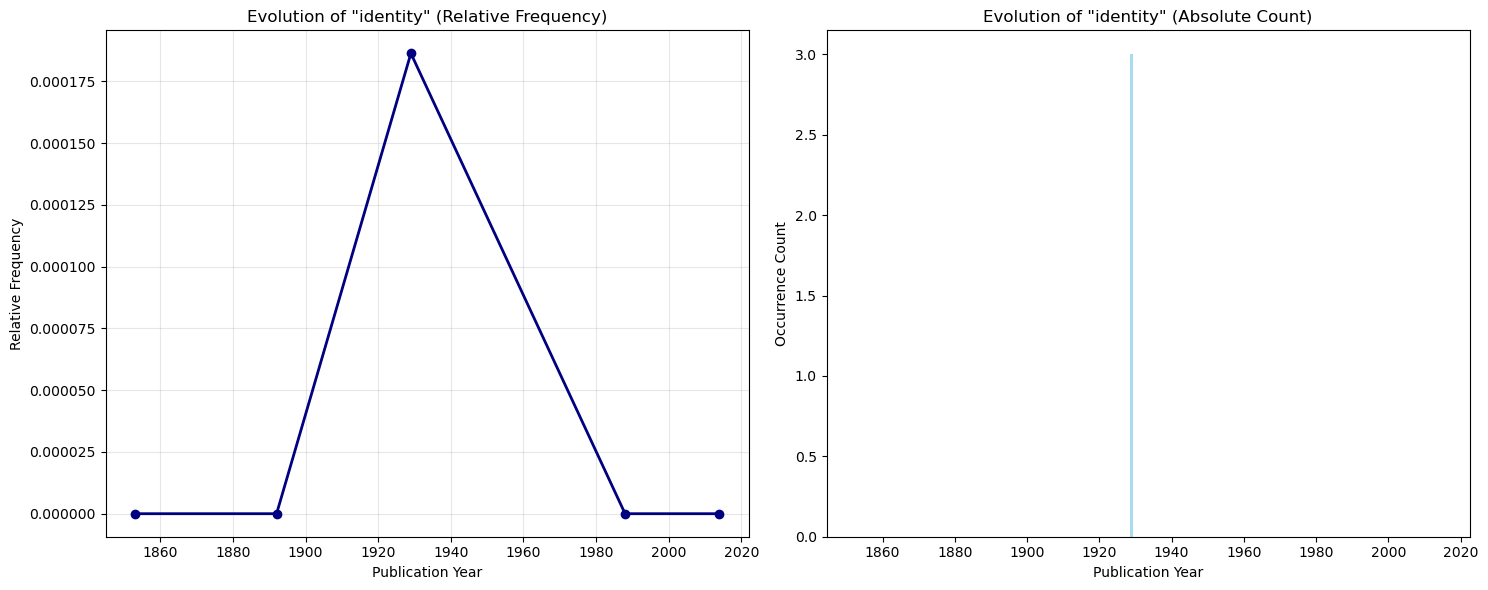


=== CONTEXTUAL SUMMARY: 'IDENTITY' ===


NameError: name 'analyzed_books' is not defined

In [51]:
def main():
    """Primary analysis workflow"""
    # Initialize resources
    initialize_nltk_resources()
    tools = initialize_linguistic_tools()
    
    # Configure book paths (update with actual paths)
    BOOK_PATHS = {
        'Bartleby The Scrivener': 'books/bartleby_1853.txt',
        'The Yellow Wallpaper': 'books/yellow_1892.txt',
        'Passing': 'books/nella_1929.txt',
        'A Small Place': 'books/small_place_1988.txt',
        'We Should All Be Feminists': 'books/feminist_2014.txt',
    }
    
    # Process books
    analyzed_books = {}
    book_texts = {}
    
    for title, path in BOOK_PATHS.items():
        try:
            print(f"Processing {title}...")
            text = read_book_content(path)
            book_texts[title] = text
            analyzed_books[title] = analyze_book(text, title, tools)
        except Exception as e:
            print(f"Error processing {title}: {str(e)}")
    
    # Corpus-level analysis
    tfidf_df, feature_names = calculate_tfidf(book_texts)
    itf_results = calculate_inverse_term_frequency(tfidf_df)
    evolution_df = create_evolution_table(analyzed_books)
    
    # Generate outputs
    visualize_keyword_evolution(evolution_df, 'identity', save_path='identity_evolution.png')
    generate_comprehensive_report(analyzed_books, evolution_df)
    
    # Save results
    evolution_df.to_csv('linguistic_evolution.csv', index=False)
    print("\nAnalysis complete. Results saved to:")
    print("  - linguistic_evolution.csv")
    print("  - identity_evolution.png")

if __name__ == "__main__":
    main()